<a href="https://colab.research.google.com/github/Ammar-Salah/amazon-reviews-Sentiment-analysis/blob/main/amazon-reviews-Sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ahmedhamdy09346_amazon_customer_reviews_path = kagglehub.dataset_download('ahmedhamdy09346/amazon-customer-reviews')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-customer-reviews/Amazon Customer Reviews.csv


# Important Libraries

In [ ]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.under_sampling import RandomUnderSampler

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amazon-customer-reviews/Amazon Customer Reviews.csv


# Data Preview

In [ ]:
data = pd.read_csv('/kaggle/input/amazon-customer-reviews/Amazon Customer Reviews.csv')

In [ ]:
data.shape

(568454, 10)

So We have **568454** reviews in our dataSet


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
print(data.isnull().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


*we have 27 null values in summary column & 26 null values in ProfileName*

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,568401.0,2.842281e+05,1.640990e+05,1.0,1.421160e+05,2.842250e+05,4.263420e+05,5.684540e+05
HelpfulnessNumerator,568401.0,1.743903e+00,7.636845e+00,0.0,0.000000e+00,0.000000e+00,2.000000e+00,8.660000e+02
HelpfulnessDenominator,568401.0,2.227911e+00,8.288820e+00,0.0,0.000000e+00,1.000000e+00,2.000000e+00,9.230000e+02
Score,568401.0,4.183297e+00,1.310376e+00,1.0,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
Time,568401.0,1.296261e+09,4.803804e+07,939340800.0,1.271290e+09,1.311120e+09,1.332720e+09,1.351210e+09


# EDA

In [ ]:
# Convert Unix timestamp to datetime
data['date'] = pd.to_datetime(data['Time'], unit='s')

# break down date to only year column
data['year'] = data['date'].dt.year
data.drop(['Time', 'date'], inplace=True, axis=1)

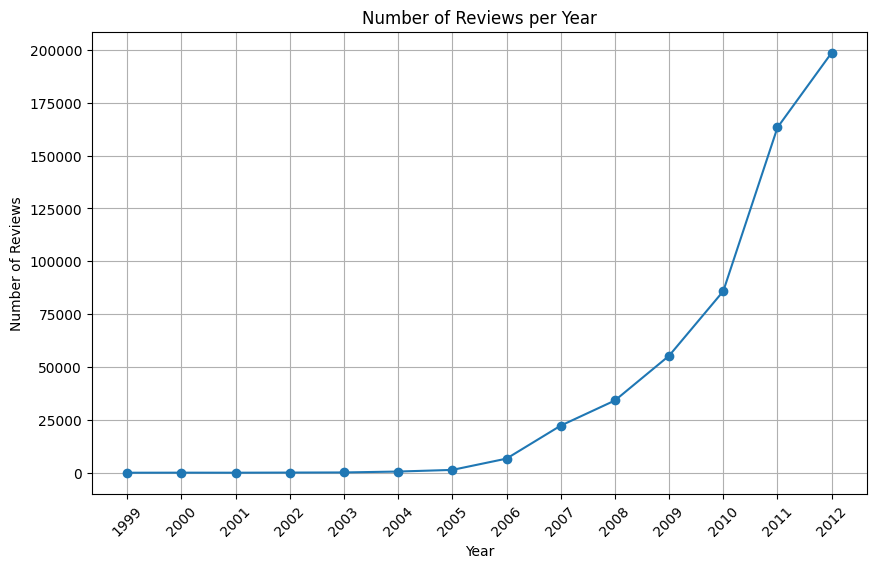

In [ ]:
# time series analysis - reviews per year
reviews_per_year = data.groupby('year').size().reset_index(name='count')

# plotting
plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year['year'], reviews_per_year['count'], marker='o')
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(reviews_per_year['year'], rotation=45)
plt.grid()
plt.show()

**The chart above shows:**

A constant growth in reviews.

In [ ]:
#sorting scores
score_counts = data['Score'].value_counts().sort_index()

In [ ]:
#Sentiment Labeling Based on Score
def label_sentiment(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    elif score in [4, 5]:
        return 'Positive'

data['Sentiment'] = data['Score'].apply(label_sentiment)

In [ ]:
# combining Summary column with text column and lower the result

In [ ]:
data['combined_text'] = data['Summary'] + ' ' + data['Text']
data.drop(['Text', 'Summary'], axis=1, inplace=True)
data['combined_text'] = data['combined_text'].str.lower()

In [ ]:
temp = data.groupby('Sentiment').count()['combined_text'].reset_index().sort_values(by='combined_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Sentiment,combined_text
2,Positive,443756
0,Negative,82007
1,Neutral,42638


In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.Sentiment,
    values = temp.combined_text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

*as we can see that the data is imbalanced, we will fix it latter*

deleting unessary columns

In [ ]:
data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,year,Sentiment,combined_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011,Positive,good quality dog food i have bought several of...


In [ ]:
data.drop(['Id','ProductId', 'UserId', 'ProfileName', 'year', 'HelpfulnessNumerator','HelpfulnessDenominator', 'Score'], axis=1, inplace=True)

# Data Preparation

In [ ]:
data['combined_text'] = data['combined_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data['combined_text'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,1886364
1,i,1448816
2,and,1294536
3,a,1231509
4,to,1024618
5,of,817486
6,it,791127
7,is,739043
8,this,654931
9,for,578618


the problem is there are many stopwords so we should handle it

In [ ]:
# Removal of Punctuations

In [ ]:
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation_from_word_list(word_list):
    """custom function to remove the punctuation from a list of words"""
    return [word.translate(str.maketrans('', '', PUNCT_TO_REMOVE)) for word in word_list]

# Apply to the combined_text column which is already a list of words
data["combined_text"] = data["combined_text"].apply(lambda word_list: remove_punctuation_from_word_list(word_list))

In [ ]:
# Removal of stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords_from_list(word_list):
    """custom function to remove the stopwords from a list of words"""
    return [word for word in word_list if word not in STOPWORDS]

data["combined_text"] = data["combined_text"].apply(lambda word_list: remove_stopwords_from_list(word_list))

In [ ]:
# Apply lemmatization to the temp_list column to reduce words to their base form.

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_words_in_list(word_list):
    # Apply lemmatization to each word in the list
    return [lemmatizer.lemmatize(word) for word in word_list]

# Apply lemmatization to the combined_text column which is a list of words
data["combined_text"] = data["combined_text"].apply(lambda word_list: lemmatize_words_in_list(word_list))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# showing top common words after deleting stopwords and punctuations

In [ ]:
top = Counter([item for sublist in data['combined_text'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [ ]:
Positive_sent = data[data['Sentiment']=='Positive']
Negative_sent = data[data['Sentiment']=='Negative']
Neutral_sent = data[data['Sentiment']=='Neutral']

In [ ]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['combined_text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10))
temp_positive.columns = ['Common_words','count']
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
top = Counter([item for sublist in Negative_sent['combined_text'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Negative Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
top = Counter([item for sublist in Neutral_sent['combined_text'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

# Modelling

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Join the list of words back into a single string for each row
data['combined_text'] = data['combined_text'].apply(lambda x: ' '.join(x))

X = data['combined_text'].values
Y = data['Sentiment'].values

vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [ ]:
Y = data['Sentiment'].map({'Positive': 1, 'Negative': 2, 'Neutral': 3}).values

In [ ]:
# Apply RandomUnderSampler for class balancing
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, Y)

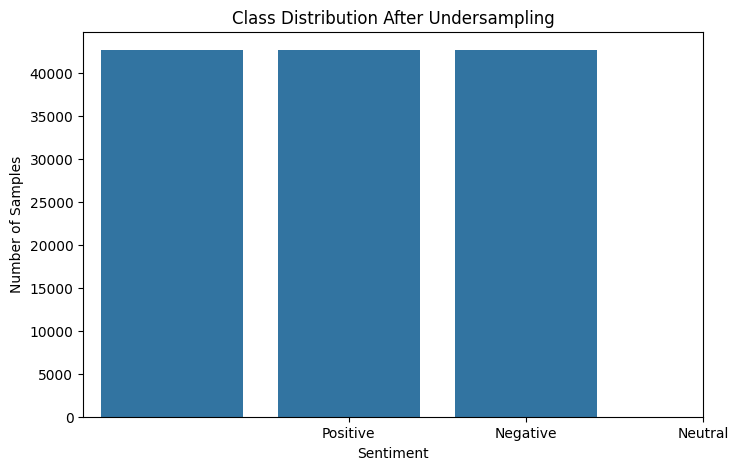

In [ ]:
# Visualize the class distribution after undersampling
unique, counts = np.unique(y_resampled, return_counts=True)
plt.figure(figsize=(8, 5))
sns.barplot(x=unique, y=counts)
plt.title('Class Distribution After Undersampling')
plt.xlabel('Sentiment')
plt.ylabel('Number of Samples')
plt.xticks(ticks=unique, labels=['Positive', 'Negative', 'Neutral'])
plt.show()

In [ ]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=200)

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, y_pred))

# Decode predicted labels back to strings
target_names = ['Positive', 'Negative', 'Neutral']
print(classification_report(Y_test, y_pred, target_names=target_names))

Accuracy: 0.8939979310490426
              precision    recall  f1-score   support

    Positive       0.92      0.98      0.95    110588
    Negative       0.81      0.76      0.78     20812
     Neutral       0.65      0.30      0.41     10701

    accuracy                           0.89    142101
   macro avg       0.79      0.68      0.71    142101
weighted avg       0.88      0.89      0.88    142101



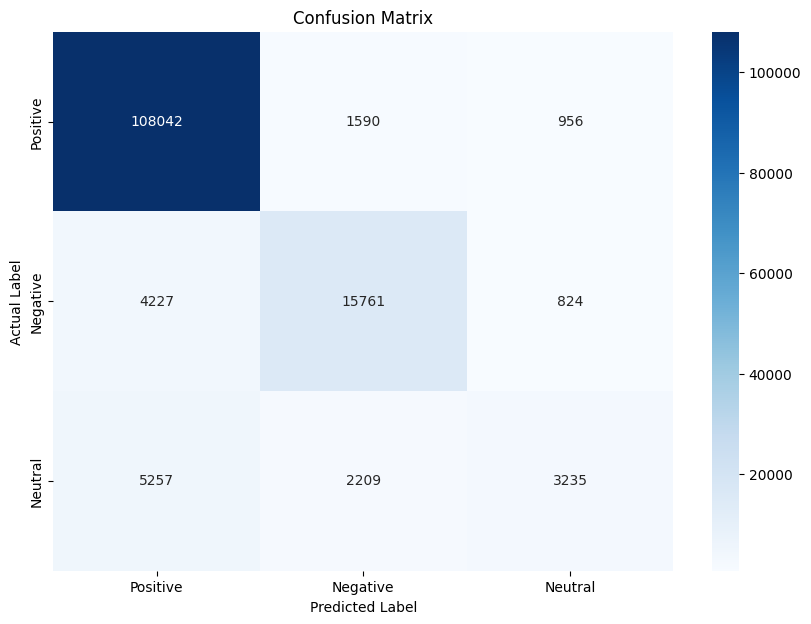

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, y_pred)
class_names = ['Positive', 'Negative', 'Neutral']

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Accuracy: 0.902273734878713
              precision    recall  f1-score   support

    Positive       0.93      0.98      0.95    110588
    Negative       0.81      0.79      0.80     20812
     Neutral       0.71      0.35      0.47     10701

    accuracy                           0.90    142101
   macro avg       0.82      0.70      0.74    142101
weighted avg       0.89      0.90      0.89    142101



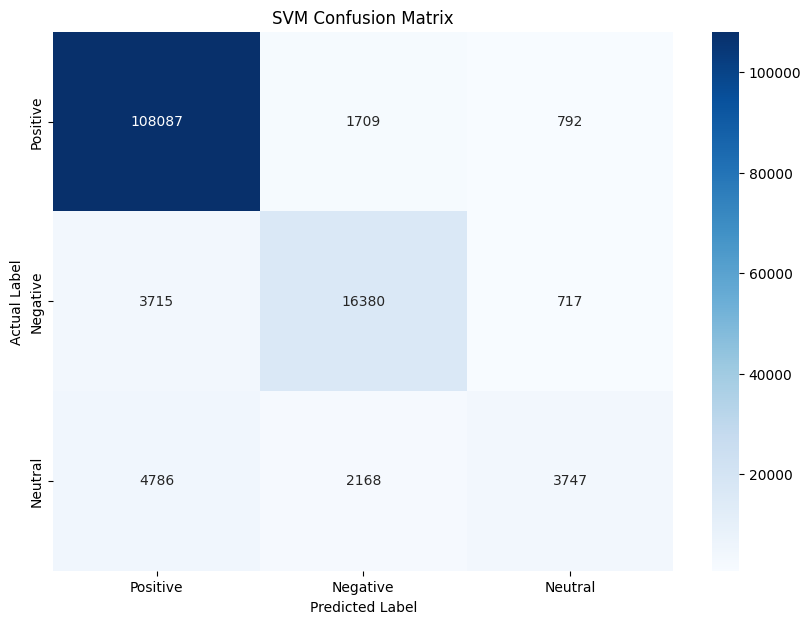

In [ ]:
from sklearn.svm import LinearSVC

# Train a Linear SVM model
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, Y_train)

# Make predictions and evaluate the model
y_pred_svm = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, y_pred_svm))
print(classification_report(Y_test, y_pred_svm, target_names=target_names))

# Generate and plot the confusion matrix for the SVM model
cm_svm = confusion_matrix(Y_test, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('SVM Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

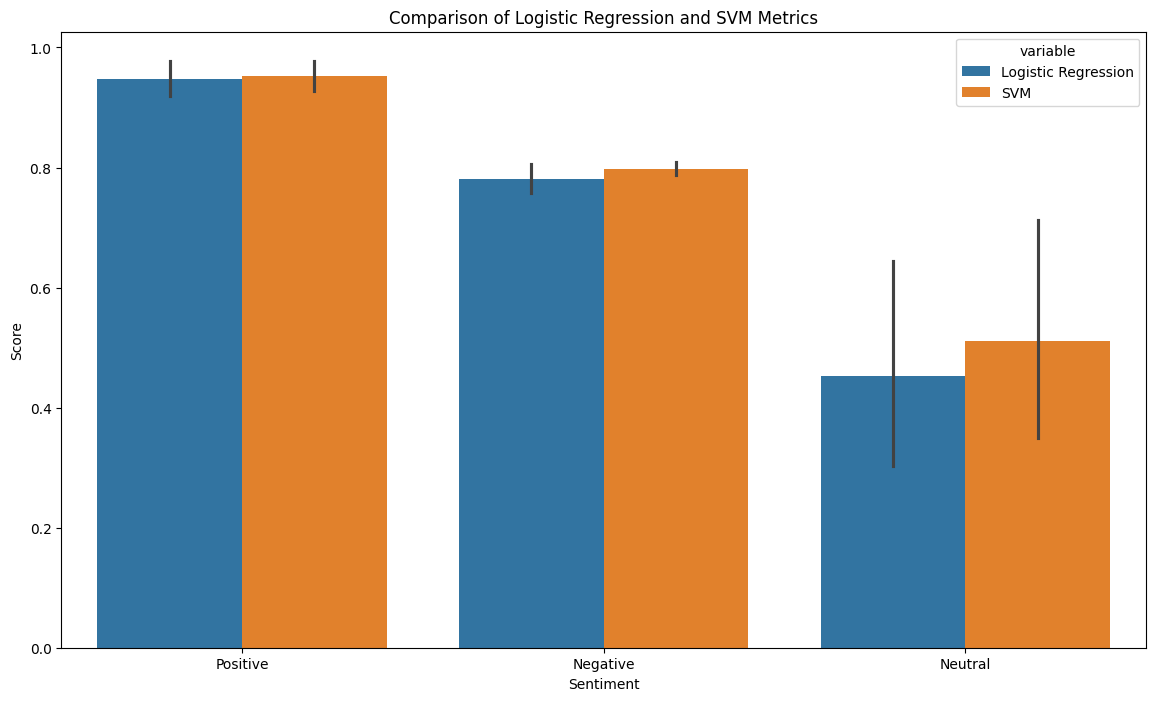

In [ ]:
# Extract classification reports as dictionaries
report_lr = classification_report(Y_test, y_pred, target_names=target_names, output_dict=True)
report_svm = classification_report(Y_test, y_pred_svm, target_names=target_names, output_dict=True)

# Create a DataFrame for plotting
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'] * 3,
    'Sentiment': ['Positive'] * 3 + ['Negative'] * 3 + ['Neutral'] * 3,
    'Logistic Regression': [
        report_lr['Positive']['precision'], report_lr['Positive']['recall'], report_lr['Positive']['f1-score'],
        report_lr['Negative']['precision'], report_lr['Negative']['recall'], report_lr['Negative']['f1-score'],
        report_lr['Neutral']['precision'], report_lr['Neutral']['recall'], report_lr['Neutral']['f1-score'],
    ],
    'SVM': [
        report_svm['Positive']['precision'], report_svm['Positive']['recall'], report_svm['Positive']['f1-score'],
        report_svm['Negative']['precision'], report_svm['Negative']['recall'], report_svm['Negative']['f1-score'],
        report_svm['Neutral']['precision'], report_svm['Neutral']['recall'], report_svm['Neutral']['f1-score'],
    ]
})

# Plot the grouped bar chart
plt.figure(figsize=(14, 8))
sns.barplot(x='Sentiment', y='value', hue='variable',
            data=pd.melt(metrics_df, id_vars=['Sentiment', 'Metric'], value_vars=['Logistic Regression', 'SVM']))
plt.ylabel('Score')
plt.title('Comparison of Logistic Regression and SVM Metrics')
plt.show()

In [ ]:
import pickle
import streamlit as st

In [ ]:
!pip install streamlit
!pip install transformers
!pip install streamlit_extras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.8/680.8 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.4/635.4 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
with open("svc_model.pkl", "wb") as f:
    pickle.dump(svm_model, f)

with open("logistic_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


In [ ]:
%%writefile app.py

# Load all models and vectorizer
@st.cache_resource()
def load_models_and_vectorizer():
    with open("svc_model.pkl", "rb") as f:
        svc_model = pickle.load(f)
    with open("logistic_model.pkl", "rb") as f:
        logistic_model = pickle.load(f)
    with open("vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)
    return svc_model, logistic_model, vectorizer

svc_model, logistic_model, vectorizer = load_models_and_vectorizer()

# Label mapping
label_map = {2: "Negative", 3: "Neutral", 1: "Positive"}
label_emoji = {"Negative": "😞", "Neutral": "😐", "Positive": "😃"}

# App UI
st.set_page_config(page_title="Sentiment Classifier", page_icon="🧠")
st.title('🧠 Sentiment Analyzer')
st.markdown("Choose a model and enter a review to classify its sentiment.")

# Sidebar for model selection
model_choice = st.sidebar.radio("Select Model", ("SVM", "Logistic Regression"))

# Text input
user_input = st.text_area("✍️ Enter your product review:", height=200)

# Predict on button click
if st.button("🔍 Analyze Sentiment"):
    if user_input.strip() != "":
        with st.spinner("Analyzing..."):
            X = vectorizer.transform([user_input])

            if model_choice == "SVM":
                prediction = svc_model.predict(X)[0]
            else:
                prediction = logistic_model.predict(X)[0]

            label = label_map[prediction]
            emoji = label_emoji[label]

            st.markdown("---")
            st.subheader(f"Sentiment: {label} {emoji}")
            st.markdown("---")
    else:
        st.error("❗ Please enter some text.")

# Sidebar info
st.sidebar.markdown("## ℹ️ About")
st.sidebar.info(
    "This app classifies review sentiment using either a Support Vector Machine or "
    "Logistic Regression model trained on Amazon customer reviews."
)
st.sidebar.markdown("### 💡 Examples")
st.sidebar.write("✔️ 'Great product and fast shipping!' → Positive")
st.sidebar.write("😐 'It’s fine, not what I expected.' → Neutral")
st.sidebar.write("❌ 'Terrible experience, never again.' → Negative")

# Footer
st.markdown(
    """
    <div style="text-align:center; padding-top: 10px; font-size: 16px;">
        🚀 Developed by: <b>Ammar Salah</b>, <b>Amira El Sayed</b>, <b>Ahmed Shaaban</b><br>
    </div>
    """,
    unsafe_allow_html=True
)


Writing app.py


In [ ]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
added 22 packages in 3s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸

In [ ]:
!curl ipv4.icanhazip.com

34.125.109.107


In [ ]:
!streamlit run app.py &>./logs.txt & npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙your url is: https://purple-webs-refuse.loca.lt
^C
